In [1]:
from google.colab import files
# file_uploaded=files.upload()

# lib

In [2]:
!pip install sentencepiece

In [3]:
import sentencepiece as spm
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
!pip install tqdm

In [5]:
from tqdm import tqdm
import json

# vocab

In [6]:
vocab_file = "news2.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

# Config

In [7]:
""" configuration json을 읽어들이는 class """
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [8]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_dec_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


# Common Class

**Positional Encoding**

Positional Embedding 초기 값을 구하는 함수

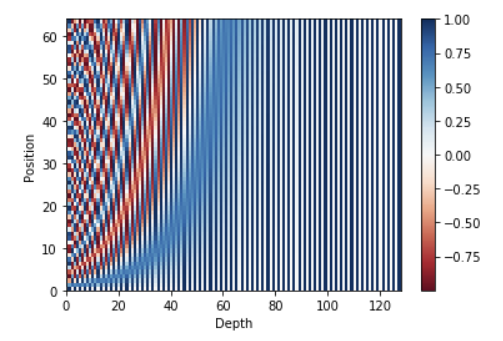

In [9]:
""" sinusoid position encoding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)]) # 각 position별 hidden index별 angle값
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

**Attention Padmask**

Attention을 구할 때 Padding 부분을 제외하기 위한 Mask를 구하는 함수

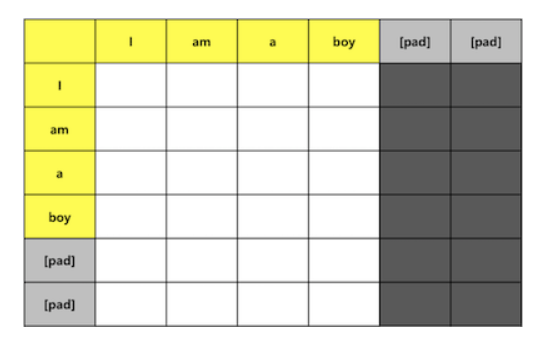

In [10]:
""" attention pad mask """
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad) # K의 값 중에 Pad인 부분을 True로 변경 (나머지는 False)
    pad_attn_mask= pad_attn_mask.unsqueeze(1).expand(batch_size, len_q, len_k) # 구해진 값의 크기를 Q-len, K-len이 되도록 변경
    return pad_attn_mask

**Attention Decoder Mask**

Decoder의 ‘Masked Multi Head Attention’에서 사용할 Mask를 구하는 함수

현재단어와 이전단어는 볼 수 있고 다음단어는 볼 수 없도록 Masking

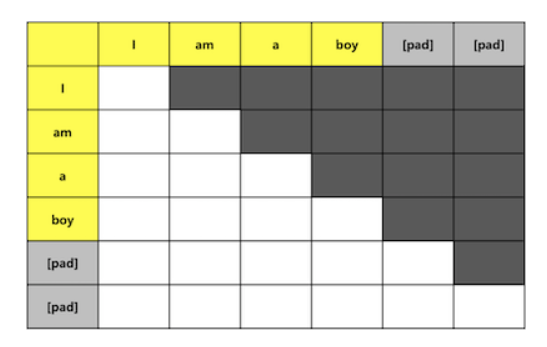

In [11]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1)) # 모든 값이 1인 Q-len, K-len 테이블 생성
    subsequent_mask = subsequent_mask.triu(diagonal=1) # 대각선을 기준으로 아래쪽 0으로
    return subsequent_mask

**Scaled Dot Product Attention**

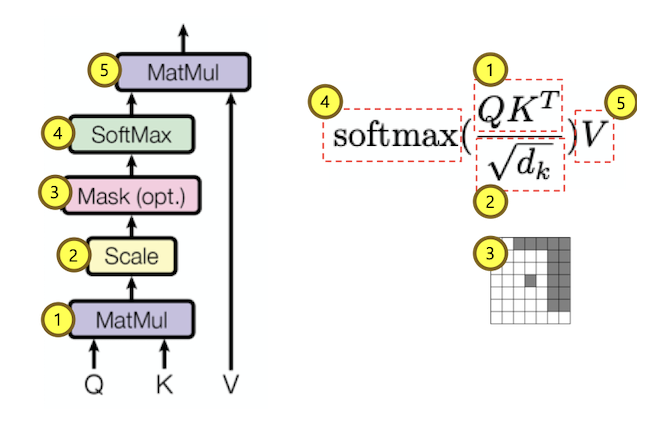

In [12]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)

    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)) # 1. Q * K.transpose를 구함
        scores = scores.mul_(self.scale) # 2. K-dimension에 루트를 취한 값으로 나눔
        scores.masked_fill_(attn_mask, -1e9) # 3. Mask 적용
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores) # 4. Softmax를 취해 각 단어의 가중치 확률분포 attn_prob 구함
        attn_prob = self.dropout(attn_prob)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V) # 5. attn_prob * V: 구한 값은 Q에 대한 V의 가중치 합 벡터
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

**Muti-Head Attention**

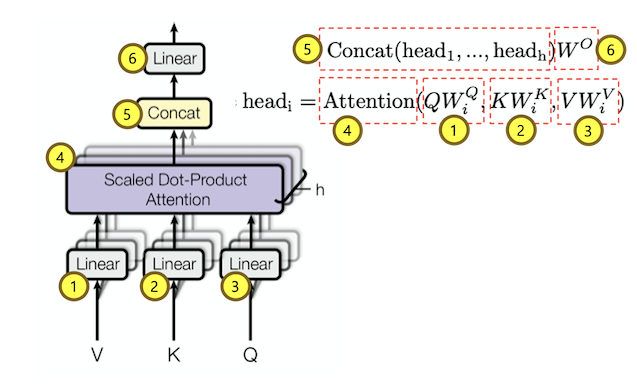

In [13]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2) # 1. Q*W_Q를 한 후 multi-head로 나눔
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2) # 2. K*W_K를 한 후 multi-head로 나눔
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2) # 3. V*W_V를 한 후 multi-head로 나눔

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask) # 4. ScaledDotProductAttention 클래스를 이용해 각 head별 Attention을 구함
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head) # 5. 여러 개의 head를 1개로 합침
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context) # 6. Linear를 취해 최종 Multi-Head Attention 값 구함
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

**FeedForward**

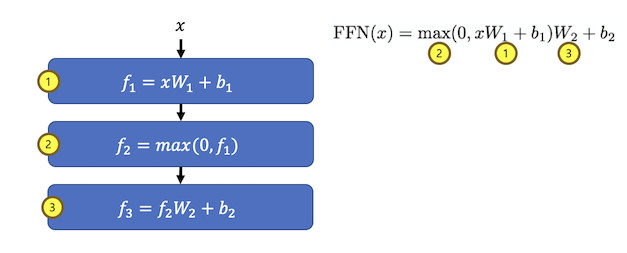

In [14]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.conv1(inputs.transpose(1, 2)) # 1. Linear를 실행하여 shape을 d_ff(hidden*4) 크기로 키움
        output = self.active(output) # activation 함수(relu or gelu) 실행
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2) # Linear를 실행하여 shape을 hidden 크기로 줄임
        output = self.dropout(output)
        # (bs, n_seq, d_hidn)
        return output

# Encoder

**Encoder Layer**

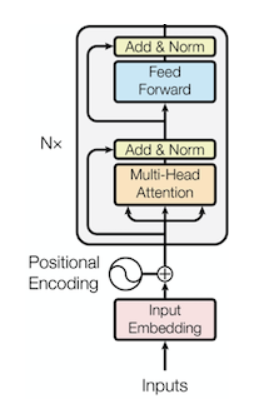

In [15]:
""" encoder layer """
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)

    def forward(self, inputs, attn_mask):
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask) # 1. Multi-Head Attention 수행 (Q,K,V 모두 동일한 값을 사용하는 self-attention)
        att_outputs = self.layer_norm1(inputs + att_outputs) # 2. 1의 결과와 input(residul)을 더한 후 LayerNorm 실행
        # (bs, n_enc_seq, d_hidn)
        ffn_outputs = self.pos_ffn(att_outputs) # 3. 2의 결과를 입력으로 FeedForward 실행
        ffn_outputs = self.layer_norm2(ffn_outputs + att_outputs) # 4. 3의 결과와 2의 결과(residual)을 더한 후 LayerNorm 실행
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        return ffn_outputs, attn_prob

**Encoder Class**

In [16]:
""" encoder """
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_enc_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])

    def forward(self, inputs):
        # 입력에 대한 Postion값 구하기
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_enc_seq, d_hidn)
        outputs = self.enc_emb(inputs) + self.pos_emb(positions) # Input Embedding과 Position Embedding을 구한 후 더함

        # (bs, n_enc_seq, n_enc_seq)
        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad) # 입력에 대한 attention pad mask를 구함

        attn_probs = []
        for layer in self.layers:
            # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
            outputs, attn_prob = layer(outputs, attn_mask) # for 루프를 돌며 각 layer 실행
            attn_probs.append(attn_prob)
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, attn_probs

# Decoder

**Decoder Layer**

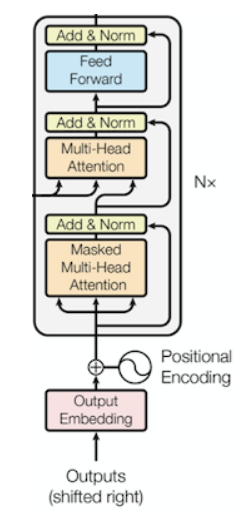

In [17]:
""" decoder layer """
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)

    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask) # 1. Multi-Head Attention 수행 (Q,K,V 모두 동일한 값을 사용하는 self-attention)
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs) # 2. 1의 결과와 input(residual) 더한 후 LayerNorm 실행
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_enc_seq)
        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask) # 3. Encoder-Decoder Multi-Head Attention 수행 (Q:2의 결과, K,V:Encoder 결과)
        dec_enc_att_outputs = self.layer_norm2(self_att_outputs + dec_enc_att_outputs) # 4. 3의 결과와 2의 결과(residual)을 더한 후 LayerNorm 실행
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_ffn(dec_enc_att_outputs) # 5. 4의 결과를 입력으로 FeedForward 실행
        ffn_outputs = self.layer_norm3(dec_enc_att_outputs + ffn_outputs) # 6. 5의 결과와 4의 결과(residual) 더한 후 LayerNorm 실행
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob

**Decoder Class**

In [18]:
""" decoder """
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        # 입력에 대한 Position값 구하기
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_dec_seq, d_hidn)
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions) # Input Embedding과 Position Embedding 구한 후 더함

        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad) # 입력에 대한 attention pad mask를 구함
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs) # 입력에 대한 decoder attention mask를 구함
        # (bs, n_dec_seq, n_dec_seq)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0) # attention pad mask와 decoder attention mask 중 1곳이라도 mask되어 있는 부분은 mask되도록 attention mask를 구함
        # (bs, n_dec_seq, n_enc_seq)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad) # Q(decoder input), K(encoder output)에 대한 attention mask를 구함

        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq), (bs, n_dec_seq, n_enc_seq)
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
        # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)], [(bs, n_dec_seq, n_enc_seq)]S
        return dec_outputs, self_attn_probs, dec_enc_attn_probs

# Transformer

In [19]:
""" transformer """
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)

    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs) # Encoder Input을 입력으로 Encoder 실행
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs) # Encoder Output과 Decoder Input을 입력으로 Decoder 실행
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

# Model

In [20]:
""" fake news classfication """
class FakeNewsClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = Transformer(self.config)
        self.projection = nn.Linear(self.config.d_hidn, self.config.n_output, bias=False)

    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_dec_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs = self.transformer(enc_inputs, dec_inputs) # Encoder input과 Decoder input을 입력으로 Transformer 모델 실행
        # (bs, d_hidn)
        dec_outputs, _ = torch.max(dec_outputs, dim=1) # Transformer 출력의 max값 구함
        # (bs, n_output)
        logits = self.projection(dec_outputs) # Linear를 실행하여 최종 예측 결과 생성
        # (bs, n_output), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return logits, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

# Dataset

**Dataset**

In [23]:
""" fake news dataset """
class FakeNewsDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            # 파일의 총 줄 수를 미리 파악하여 tqdm에 전달
            line_cnt = sum(1 for _ in f)
            f.seek(0)  # 파일 포인터를 처음으로 되돌림

            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                data = json.loads(line)
                label = data["label"]
                # 단어 필터링: vocab에 없는 단어는 제외
                doc = [self.vocab.piece_to_id(p) for p in data["doc"] if self.vocab.piece_to_id(p) != self.vocab.unk_id()]
                if not doc:
                    continue  # 문서가 비어 있으면 제외

                self.labels.append(label)
                self.sentences.append(doc)

    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        return len(self.labels)

    def __getitem__(self, item):
        return (torch.tensor(self.labels[item], dtype=torch.long),
                torch.tensor(self.sentences[item], dtype=torch.long),
                torch.tensor([self.vocab.piece_to_id("[BOS]")], dtype=torch.long)) # Decoder 입력 '[BOS]'로 고정

**collate_fn**

배치 단위 데이터 처리

In [24]:
"""collate_fn """
def collate_fn(inputs):
    labels, enc_inputs, dec_inputs = list(zip(*inputs))

    enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=0) # Encoder inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가
    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0) # Decoder inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가

    enc_inputs = enc_inputs.long()
    dec_inputs = dec_inputs.long()

    batch = [
        torch.stack(labels, dim=0), # Label은 길이가 1 고정이므로 stack 함수를 이용해 tensor로
        enc_inputs,
        dec_inputs,
    ]
    return batch

**DataLoader**

In [25]:
batch_size = 128
train_dataset = FakeNewsDataSet(vocab, "news2_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataset = FakeNewsDataSet(vocab, "news2_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Loading news2_test.json: 100%|██████████| 1259/1259 [00:04<00:00, 288.01 lines/s]


# Evaluate

In [26]:
""" 모델 epoch 평가 """
def eval_epoch(config, model, data_loader):
    matchs = []
    model.eval()

    n_word_total = 0
    n_correct_total = 0
    with tqdm(total=len(data_loader), desc=f"Valid") as pbar:
        for i, value in enumerate(data_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            outputs = model(enc_inputs, dec_inputs) # classification 실행
            logits = outputs[0] # 위의 결과 중 첫 번째 값이 예측 logits
            _, indices = logits.max(1) # logits의 최대값의 index를 구함

            match = torch.eq(indices, labels).detach() # 구한 최대값의 index와 labels의 값이 같은지 비교
            matchs.extend(match.cpu())
            accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

            pbar.update(1)
            pbar.set_postfix_str(f"Acc: {accuracy:.3f}")
    return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

# Train

In [27]:
""" 모델 epoch 학습 """
def train_epoch(config, epoch, model, criterion, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm(total=len(train_loader), desc=f"Train {epoch}") as pbar:
        for i, value in enumerate(train_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            outputs = model(enc_inputs, dec_inputs) # classification 실행
            logits = outputs[0] # 예측 logits

            loss = criterion(logits, labels) # logits값과 lables값을 이용해 loss 계산
            loss_val = loss.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

In [28]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.n_output = 2
print(config)

learning_rate = 5e-5
n_epoch = 10

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cpu'), 'n_output': 2}


In [29]:
model = FakeNewsClassification(config)
model.to(config.device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses, scores = [], []
for epoch in range(n_epoch):
    loss = train_epoch(config, epoch, model, criterion, optimizer, train_loader) # epoch 마다 학습
    score = eval_epoch(config, model, test_loader) # epoch 마다 평가

    losses.append(loss)
    scores.append(score)

Train 0:   0%|          | 0/40 [00:00<?, ?it/s]


IndexError: index out of range in self

# Result

In [ ]:
# table
data = {
    "loss": losses,
    "score": scores
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.plot(scores, label="score")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()